<a href="https://colab.research.google.com/github/wiv33/A-Learning-python/blob/master/machine-learning/_000_hello_machine/_002_examples/_001_first_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# !unzip '/content/drive/My Drive/Colab Notebooks/data/programmers_v2/train_job.zip' -d '/content/drive/My Drive/Colab Notebooks/data/programmers_v2/'

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
data_dir_path = '/content/drive/My Drive/Colab Notebooks/data/programmers_v2/'

In [5]:
import pandas as pd

def cp(s):
  return "{}{}".format(data_dir_path, s)

tags_df = pd.read_csv(cp('tags.csv'))
train_df = pd.read_csv(cp('train.csv'))
user_tag_df = pd.read_csv(cp('user_tags.csv'))
job_companies_df = pd.read_csv(cp('job_companies.csv'))
job_tag_df = pd.read_csv(cp('job_tags.csv'))

In [ ]:
tags_df.sample(5)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


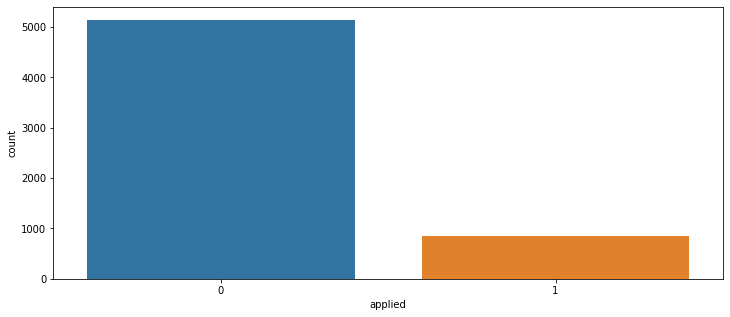

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.countplot(train_df['applied'])

In [ ]:
a = job_tag_df.groupby('jobID')
a.jobID.value_counts()

In [9]:
tags_df[tags_df['tagID'] == '8e2cfdc275761edc592f73a076197c33']['keyword'].values[0]

'Webpack'

In [10]:
def grouping_tags(df: pd.DataFrame, id: str) -> {}:
    result = []
    for u, t in df.groupby(id):
      temp = {}
      temp[id] = u
      temp['{}_tags'.format(id)] = " ".join(set(df[df[id] == u]['tagID'].apply(lambda x: tags_df[tags_df['tagID'] == x]['keyword'].values[0])))
      result.append(temp)

    return pd.DataFrame(result)

In [ ]:
job_match_df = grouping_tags(job_tag_df, 'jobID')
job_match_df.head(2)

In [ ]:
user_match_df = grouping_tags(user_tag_df, 'userID')
user_match_df.sample(2)

# train 데이터에 job과 user tag 삽입

In [13]:
merge_user = pd.merge(train_df, user_match_df, how='left')
complete_merge = pd.merge(merge_user, job_match_df, how='left')

# 정규화 필요

In [ ]:
complete_merge[complete_merge['applied'] == 1]

In [15]:
complete_merge['job_tags_split'] = complete_merge['jobID_tags'].apply(lambda x: x.split(","))
complete_merge['user_tags_split'] = complete_merge['userID_tags'].apply(lambda x: x.split(","))

In [ ]:
complete_merge

In [17]:
complete_merge['userID_tags'].sample().apply(lambda x: x.split(",")).tolist()

[['MyBatis MySQL Node.js Firebase MariaDB Ajax Axios Spring Google Analytics Next.js Java Persistence API ReactJS Elasticsearch Vuex jQuery Amazon Web Services(AWS) Java Bootstrap Vue.js Python JavaScript JSP Spring Boot Redux.js']]

In [18]:
from sklearn.metrics.pairwise import euclidean_distances

def l1_normalize(v):
    return v / np.sum(v)

# euclidean_distances(tfidf_metric[:, :, 2], tfidf_metric[:, :, 1])

## 첫 번째 시도



In [19]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import numpy as np 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(complete_merge['userID_tags'])
tag_sequences = tokenizer.texts_to_sequences(complete_merge['userID_tags'])
tag_vocab = tokenizer.word_index


tag_vocab
# tokenizer.texts_to_sequences()

In [ ]:
complete_merge

## 두 번째 시도


In [ ]:
df_fit = complete_merge['userID_tags'].append(complete_merge['jobID_tags'])
df_fit

In [ ]:
complete_merge.head(2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(df_fit)
print(vectorizer.get_feature_names())
vocab = vectorizer.vocabulary_
print(vocab)

In [83]:
def trans(col):
  return vectorizer.transform([col]).toarray()

In [84]:
complete_merge['job_tag'] = complete_merge['jobID_tags'].apply(trans)
complete_merge['user_tag'] = complete_merge['userID_tags'].apply(trans)

In [85]:
df_train = complete_merge.iloc[:, 7:]
df_train['applied'] = complete_merge.iloc[:, 2]

In [88]:
np.array(df_train['job_tag'].sample(1)) * np.array(df_train['user_tag'].sample(1))

array([array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.       

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

decision = DecisionTreeClassifier()
decision.fit(complete_merge.iloc[:, 5:], complete_merge.iloc[:, 2])


유저의 태그를 문자열로 붙여 `새로운 컬럼`에 추가한다.

job의 태그를 문자열로 붙여 `새로운 컬럼`에 추가한다.

companies를 벡터화에 추가한다.

job의 `새로운 컬럼`에 company를 덧붙인다.